In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder

### Transformei a base de dados de .xlsx para .csv para agilizar o processamento do pandas, sem a necessidade do 'openpyxl'

Se necessitar converter, favor descomentar a célula

In [2]:
#df = pd.read_excel("../dataset/csgo_round_snapshots.xlsx")
#df.to_csv("../dataset/csgo_round_snapshots.csv", index=False)

Essa transformação reduziu o tempo de execução de 30s para 0.3s

# Parte 1

### Leitura do arquivo .csv para df, com pandas.

In [3]:
df = pd.read_csv('../dataset/csgo_round_snapshots.csv')

In [4]:
df.head()

,time_left,ct_score,t_score,map,ct_health,t_health,ct_money,t_money,ct_helmets,t_helmets,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0,0,de_dust2,500,500,4000,4000,0,0,...,0,0,0,0,0,0,0,0,0,CT
1,156.03,0,0,de_dust2,500,500,600,650,0,0,...,0,0,2,0,0,0,0,0,0,CT
2,96.03,0,0,de_dust2,391,400,750,500,0,0,...,0,0,2,0,0,0,0,0,0,CT
3,76.03,0,0,de_dust2,391,400,750,500,0,0,...,0,0,0,0,0,0,0,0,0,CT
4,174.97,1,0,de_dust2,500,500,18350,10750,0,0,...,0,0,0,0,0,0,0,0,0,CT


### Dicionário dos dados, para referência.

Adiquirido de base similar, em [https://www.kaggle.com/datasets/christianlillelund/csgo-round-winner-classification](Kaggle)

```
Variable	        Definition	                                            Key
time_left	        The time left in the current round.	
ct_score	        The current score of the Counter-Terrorist team.	
t_score	                The current score of the Terrorist team.	
map	                The map the round is being played on.	                    E.g. de_dust2, de_inferno and de_overpass
bomb_planted	        If the bomb has been planted or not.	                    False = No, True = Yes
ct_health	        The total health of all Counter-Terrorist players.	    Player health in range 0-100.
t_health	        The total health of all Terrorist players.	            Player health in range 0-100.
ct_armor	        The total armor of all Counter-Terrorist players.	
t_armor	                The total armor of all Terrorist players.	
ct_money	        The total bankroll of all Counter-Terrorist players.	    Amount in USD.
t_money	                The total bankroll of all Terrorist players.	            Amount in USD.
ct_helmets	        Number of helmets on the Counter-Terrorist team.	
t_helmets	        Number of helmets on the Terrorist team.	
ct_defuse_kits	        Number of defuse kits on the Counter-Terrorist team.	
ct_players_alive	Number of alive players on the Counter-Terrorist team.	    Range 0 to 5.
t_players_alive	        Number of alive players on the Terrorist team.	            Range 0 to 5.
ct_weapon_X	        Weapon X count on Counter-Terrorist team.	            E.g. Ak47, Deagle and UMP45.
t_weapon_X	        Weapon X count on Terrorist team.	                    E.g. Ak47, Deagle and UMP45.
ct_grenade_X	        Grenade X count on Counter-Terrorist team.	            E.g. HeGrenade, Flashbang.
t_grenade_X	        Grenade X count on Terrorist team.	                    E.g. HeGrenade, Flashbang.
round_winner	        Winner.	                                                    CT = Counter-Terrorist, T = Terrorist
```

A base utilizada possui colunas para cada arma(utilizada ou não) em toda a partida.

### Tratamento de dados

Para começar, visualizei se existiam dados nulos ou se havia algum tipo errado.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122410 entries, 0 to 122409
Data columns (total 94 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   time_left                     122410 non-null  float64
 1   ct_score                      122410 non-null  int64  
 2   t_score                       122410 non-null  int64  
 3   map                           122410 non-null  object 
 4   ct_health                     122410 non-null  int64  
 5   t_health                      122410 non-null  int64  
 6   ct_money                      122410 non-null  int64  
 7   t_money                       122410 non-null  int64  
 8   ct_helmets                    122410 non-null  int64  
 9   t_helmets                     122410 non-null  int64  
 10  ct_defuse_kits                122410 non-null  int64  
 11  ct_players_alive              122410 non-null  int64  
 12  t_players_alive               122410 non-nul

Conferi que todas as linhas possuem valores e seus tipos estão corretos.

Mas possuem valores divergentes do padrão para uma partida de CS:GO.

In [6]:
with pd.option_context("display.max_rows", None):
    print(df.max())

time_left                            175.0
ct_score                                32
t_score                                 33
map                             de_vertigo
ct_health                              500
t_health                               600
ct_money                             80000
t_money                              80000
ct_helmets                               5
t_helmets                                5
ct_defuse_kits                           5
ct_players_alive                         5
t_players_alive                          6
ct_weapon_ak47                           4
t_weapon_ak47                            5
ct_weapon_aug                            5
t_weapon_aug                             3
ct_weapon_awp                            5
t_weapon_awp                             4
ct_weapon_bizon                          0
t_weapon_bizon                           1
ct_weapon_cz75auto                       5
t_weapon_cz75auto                        6
ct_weapon_e

Pesquisei todas as anomalias e percebi que todas elas ocorrem no segundo inicial do round, sendo duplicadas logo em seguida com os valores corretos, podendo então serem excluídas.

In [7]:
with pd.option_context("display.max_columns", None):
    print(df[df['t_weapon_glock'] > 5])

        time_left  ct_score  t_score         map  ct_health  t_health  \
15913      175.00         7       12   de_mirage        500       500   
21467      175.00        10        2    de_dust2        500       500   
24678      175.00        15       15    de_train        500       500   
32658      175.00         1        0   de_mirage        500       500   
53147      175.00         0        6   de_mirage        500       500   
58271      175.00         0        0  de_vertigo        400       600   
77404      169.94        15       15    de_dust2        500       500   
87764      175.00         9       14   de_mirage        500       500   
96835      175.00         2        4     de_nuke        500       500   
98359      175.00         6        2  de_inferno        500       500   
116993     175.00         4        5   de_mirage        500       500   
120215     175.00         7        7  de_inferno        500       500   
120896     175.00         1        0     de_nuke   

A linha seguinte à 15913 contém o mesmo valor de time_left, mas com o restante dos valores corretos.

In [8]:
print(df.iloc[15914])

time_left                       165.88
ct_score                             7
t_score                             12
map                          de_mirage
ct_health                          500
                               ...    
ct_grenade_molotovgrenade            0
t_grenade_molotovgrenade             1
ct_grenade_decoygrenade              0
t_grenade_decoygrenade               0
round_winner                        CT
Name: 15914, Length: 94, dtype: object


Com base no `describe()` e `max()`, pude detectar outliers em algumas colunas, como em `t_health` que possui um valor de 600, sendo que cada jogador só pode ter 100 de health e cada time possui 5 jogadores.

Removendo as linhas com valores maiores que 500 em t_health. Após conferir que a linha estava duplicada e continha erro.

In [9]:
with pd.option_context("display.max_columns", None):
    print(df[df['t_weapon_cz75auto'] > 5])

       time_left  ct_score  t_score         map  ct_health  t_health  \
98707      175.0         1        1  de_inferno        500       500   

       ct_money  t_money  ct_helmets  t_helmets  ct_defuse_kits  \
98707      9150    17450           0          3               0   

       ct_players_alive  t_players_alive  ct_weapon_ak47  t_weapon_ak47  \
98707                 5                5               0              0   

       ct_weapon_aug  t_weapon_aug  ct_weapon_awp  t_weapon_awp  \
98707              0             0              0             0   

       ct_weapon_bizon  t_weapon_bizon  ct_weapon_cz75auto  t_weapon_cz75auto  \
98707                0               0                   0                  6   

       ct_weapon_elite  t_weapon_elite  ct_weapon_famas  t_weapon_famas  \
98707                0               0                0               0   

       ct_weapon_g3sg1  t_weapon_g3sg1  ct_weapon_galilar  t_weapon_galilar  \
98707                0               0   

In [10]:
with pd.option_context("display.max_columns", None):
    print(df[df['t_health'] > 500])

       time_left  ct_score  t_score         map  ct_health  t_health  \
58271      175.0         0        0  de_vertigo        400       600   

       ct_money  t_money  ct_helmets  t_helmets  ct_defuse_kits  \
58271      3200     4800           0          0               0   

       ct_players_alive  t_players_alive  ct_weapon_ak47  t_weapon_ak47  \
58271                 4                6               0              0   

       ct_weapon_aug  t_weapon_aug  ct_weapon_awp  t_weapon_awp  \
58271              0             0              0             0   

       ct_weapon_bizon  t_weapon_bizon  ct_weapon_cz75auto  t_weapon_cz75auto  \
58271                0               0                   0                  0   

       ct_weapon_elite  t_weapon_elite  ct_weapon_famas  t_weapon_famas  \
58271                0               0                0               0   

       ct_weapon_g3sg1  t_weapon_g3sg1  ct_weapon_galilar  t_weapon_galilar  \
58271                0               0   

Para realização de validação de dados posterior, as linhas que devem ser removidas serão movidas para um dataframe diferente para tratamento futuro, caso necessário.

Irei adicionar os valores à um novo dataframe, antes de removê-los do dataset base.

In [11]:
linhas_invalidas = (
    (df['t_health'] > 500) |
    (df['t_weapon_glock'] > 5) |
    (df['t_weapon_cz75auto'] > 5) |
    (df['ct_weapon_usps'] > 5) |
    (df['t_grenade_smokegrenade'] > 5) |
    (df['ct_grenade_smokegrenade'] > 5)
)

df_erros = df[linhas_invalidas]

print("df_erros count is", df_erros.iloc[:, 0].count())


df_erros count is 22


Removo as linhas inválidas do dataset base.

In [12]:
df = df[~linhas_invalidas]

print("df count is", df.count().iloc[0])

df count is 122388


Nota-se que o mesmo erro foi eliminado das colunas `ct_players_alive` e `t_players_alive`

### Dividir a base de dados

Separa os dados dos alvos

In [13]:
X = df.drop("round_winner", axis=1) # Features
y = df['round_winner'] # Target

Encodar os alvos em 0/1.

CT = 0

T = 1

In [14]:
le = LabelEncoder()
y = le.fit_transform(y)

Separar os tipos de colunas, devido à coluna 'map'

In [15]:
cols_categoricas = X.select_dtypes(include=["object", "string"]).columns
cols_numericas = X.select_dtypes(include=["number"]).columns

Pre-processamento dos dados

In [16]:
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cols_categoricas),
        ("num", "passthrough", cols_numericas)
    ]
)

Cria a pipeline

In [17]:
modelo = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=1))
])

Divide os dados em Train e test

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

### Treinamento e resultado

Engloba e avalia o modelo

In [19]:
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

In [20]:
print("Precisão:" , accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Precisão: 0.8797267705984246
              precision    recall  f1-score   support

          CT       0.87      0.88      0.88     14999
           T       0.89      0.88      0.88     15598

    accuracy                           0.88     30597
   macro avg       0.88      0.88      0.88     30597
weighted avg       0.88      0.88      0.88     30597



Um resultado de 0,88 significa uma previsão forte.

# Parte 2

## Passo 3

Nesse passo deverá ocorrer os seguintes passos:

- Carregar o dataset;

- Inverter a divisão de dataset pela preparação de dados;

- Realizar o treinamento;

- Mostrar predições.

### Carregar o dataset

Vamos carregar o dataset o dataframe `p2_df`

In [21]:
p2_df = pd.read_csv('../dataset/csgo_round_snapshots.csv')
p2_df.head()

,time_left,ct_score,t_score,map,ct_health,t_health,ct_money,t_money,ct_helmets,t_helmets,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0,0,de_dust2,500,500,4000,4000,0,0,...,0,0,0,0,0,0,0,0,0,CT
1,156.03,0,0,de_dust2,500,500,600,650,0,0,...,0,0,2,0,0,0,0,0,0,CT
2,96.03,0,0,de_dust2,391,400,750,500,0,0,...,0,0,2,0,0,0,0,0,0,CT
3,76.03,0,0,de_dust2,391,400,750,500,0,0,...,0,0,0,0,0,0,0,0,0,CT
4,174.97,1,0,de_dust2,500,500,18350,10750,0,0,...,0,0,0,0,0,0,0,0,0,CT


### Dividir o dataset

Separamos os Features dos Targets

In [22]:
p2_X = p2_df.drop("round_winner", axis=1) # Features
p2_y = p2_df['round_winner'] # Target

Converter os valores de target em 0/1

In [23]:
p2_y = le.fit_transform(p2_y)

Separar as colunas categóricas das numéricas

In [24]:
p2_cols_categoricas = p2_X.select_dtypes(include=["object", "string"]).columns
p2_cols_numericas = p2_X.select_dtypes(include=["number"]).columns

Realizamos o pré-processamento devido as colunas categóricas

In [25]:
p2_preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), p2_cols_categoricas),
        ("num", "passthrough", p2_cols_numericas)
    ]
)

Criamos então a pipeline

In [26]:
p2_modelo = Pipeline(steps=[
    ("preprocess", p2_preprocess),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=1))
])

E dividimos entre Train e Test

In [27]:
p2_X_train, p2_X_test, p2_y_train, p2_y_test = train_test_split(
    p2_X, p2_y, test_size=0.25, random_state=42, stratify=p2_y
)

### Preparar os dados

Aproveitando os mesmos valores da variável `linhas_invalidas`, crio `linhas_invalidas_train` e `linhas_invalidas_test` para cada tipo, para não causar erro de index.

E removo os dados de Train e Test em X e y.

In [28]:
linhas_invalidas_train = (
    (p2_X_train['t_health'] > 500) |
    (p2_X_train['t_weapon_glock'] > 5) |
    (p2_X_train['t_weapon_cz75auto'] > 5) |
    (p2_X_train['ct_weapon_usps'] > 5) |
    (p2_X_train['t_grenade_smokegrenade'] > 5) |
    (p2_X_train['ct_grenade_smokegrenade'] > 5)
)

linhas_invalidas_test = (
    (p2_X_test['t_health'] > 500) |
    (p2_X_test['t_weapon_glock'] > 5) |
    (p2_X_test['t_weapon_cz75auto'] > 5) |
    (p2_X_test['ct_weapon_usps'] > 5) |
    (p2_X_test['t_grenade_smokegrenade'] > 5) |
    (p2_X_test['ct_grenade_smokegrenade'] > 5)
)

In [29]:
p2_X_train = p2_X_train[~linhas_invalidas_train]
p2_y_train = p2_y_train[~linhas_invalidas_train]

p2_X_test = p2_X_test[~linhas_invalidas_test]
p2_y_test = p2_y_test[~linhas_invalidas_test]

### Treinamento e Resultado

Engloba e avalia o modelo

In [30]:
p2_modelo.fit(p2_X_train, p2_y_train)
p2_y_pred = p2_modelo.predict(p2_X_test)

Imprimimos o resultado

In [31]:
print("Precisão:" , accuracy_score(p2_y_test, p2_y_pred))
print(classification_report(p2_y_test, p2_y_pred, target_names=le.classes_))

Precisão: 0.8800575200993529
              precision    recall  f1-score   support

          CT       0.87      0.89      0.88     14999
           T       0.89      0.87      0.88     15599

    accuracy                           0.88     30598
   macro avg       0.88      0.88      0.88     30598
weighted avg       0.88      0.88      0.88     30598



A precisão aumentou em 0,0003307495009283, o que significa que a ordem de execução não afetou tanto o modelo. Pois ambos limpam e dividem os dados, mesmo sendo antes ou depois.

## Passo 4

Nesse passo deverão serem seguidas as seguintes etapas:

- Carregar o dataset;

- Dividir o dataset entre base de treinamento e de testes;

- Criar uma pipeline que inclua:

    - Preparação de dados;

    - Treinamento do algoritmo com um algoritmo de aprendizagem supervisionada;

- Mostrar as predições do pipeline para uma base de testes;

- Escolher duas métricas para o tipo de problema que esteja trabalhando
(RMSE, MAE, MAPE, MSE para regressão || matriz de confusão, ROC e AUC, precision e recall, balanced accuracy e F1 score para classificação);

- Mostrar as métricas por meio da base de testes selecionada.

### Carregando o dataset

Carregar o dataset para um novo dataframe `p3_df`

In [32]:
p3_df = pd.read_csv('../dataset/csgo_round_snapshots.csv')
p3_df.head()

,time_left,ct_score,t_score,map,ct_health,t_health,ct_money,t_money,ct_helmets,t_helmets,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0,0,de_dust2,500,500,4000,4000,0,0,...,0,0,0,0,0,0,0,0,0,CT
1,156.03,0,0,de_dust2,500,500,600,650,0,0,...,0,0,2,0,0,0,0,0,0,CT
2,96.03,0,0,de_dust2,391,400,750,500,0,0,...,0,0,2,0,0,0,0,0,0,CT
3,76.03,0,0,de_dust2,391,400,750,500,0,0,...,0,0,0,0,0,0,0,0,0,CT
4,174.97,1,0,de_dust2,500,500,18350,10750,0,0,...,0,0,0,0,0,0,0,0,0,CT


### Dividir o dataset entre Treinamento e Teste

Separamos as Features dos Targets

In [33]:
p3_X = p3_df.drop("round_winner", axis=1) # Features
p3_y = p3_df['round_winner'] # Target

Transformamos os valores dos Targets em 0/1

In [34]:
p3_y = le.fit_transform(p3_y)

Separamos as colunas categóricas das numéricas

In [35]:
p3_cols_categoricas = p3_X.select_dtypes(include=["object", "string"]).columns
p3_cols_numericas = p3_X.select_dtypes(include=["number"]).columns

Realizamos o pré-processamento para as colunas categóricas não causarem erro

In [36]:
p3_preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), p3_cols_categoricas),
        ("num", "passthrough", p3_cols_numericas)
    ]
)

Criamos uma função de `limpar_dados`

In [37]:
def limpar_dados(p3_df):
    return p3_df[
        (p3_df['t_health'] <= 500) |
        (p3_df['t_weapon_glock'] <= 5) |
        (p3_df['t_weapon_cz75auto'] <= 5) |
        (p3_df['ct_weapon_usps'] <= 5) |
        (p3_df['t_grenade_smokegrenade'] <= 5) |
        (p3_df['ct_grenade_smokegrenade'] <= 5)
    ]

Atribuímos essa função à variável `limpador` através de `FunctionTransformer`

In [38]:
limpador = FunctionTransformer(limpar_dados)

Dividimos entre Train e Test

In [39]:
p3_X_train, p3_X_test, p3_y_train, p3_y_test = train_test_split(
    p3_X, p3_y, test_size=0.25, random_state=42, stratify=p3_y
)

Criamos a pipeline, incluindo o passo de limpar os dados

In [40]:
p3_modelo = Pipeline(steps=[
    ("clean", limpador),
    ("preprocess", p3_preprocess),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=1))
])

### Treinamento e Resultado

Treinamos o modelo

In [ ]:
p3_modelo.fit(p3_X_train, p3_y_train)
p3_y_pred = p3_modelo.predict(p3_X_test)

Imprimimos as métricas:

Matriz de Confusão

In [ ]:
cm = confusion_matrix(p3_y_test, p3_y_pred)
print("Matriz de Confusão:\n", cm)

Matriz de Confusão:
 [[13315  1686]
 [ 2064 13538]]


Exibindo um grafo para facilitar visualização.

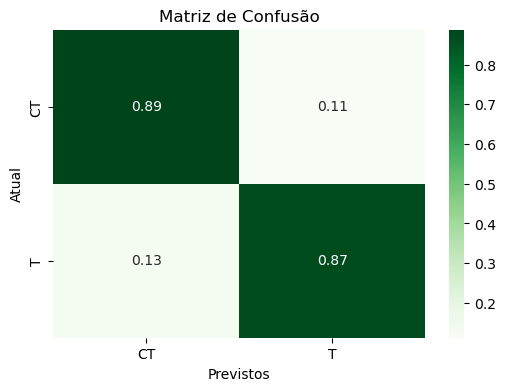

In [ ]:
plt.figure(figsize=(6,4))

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Previstos")
plt.ylabel("Atual")
plt.title("Matriz de Confusão")
plt.show()

F1 Score

In [ ]:
f1 = f1_score(p3_y_test, p3_y_pred, average="weighted")
print("F1 Score:", f1)

F1 Score: 0.8774740234043802


O precisão do modelo preditivo se manteve dentro da mesma faixa em todos os casos.
Pode-se dizer que os resultados são bons pois atingiram um percentual de acerto de ~88%, sendo um resultado de modelo preditivo bem forte.

Comparando a Parte 1 com o passo 2 da Parte 2, onde ocorreu a inversão dos papéis de divisão e tratamento de dados, notasse que a diferença no resultado não foi fator importante.